In [1]:
import numpy as np
import pandas as pd
import functions as f
import torch
from torch import autograd, nn
import torch.optim as optim
import matplotlib.pylab as plt
from tqdm import tqdm

# ALL DATASET
data = pd.read_csv('data_fs.dat', delim_whitespace=True, decimal=",")

dataset = np.stack((data["x"].values, data["y"].values, data["e"]), axis=1)
dataset = torch.from_numpy(dataset).float()

## PARAMETRI
Definisco ora tutti i parametri in modo che siano facilmente modificabili

In [2]:
input_size = 2
hidden_size = 7
activation_fun = nn.Tanh()
epochs = 50
loss_fun = nn.MSELoss()

Usando `torch.utils.data.DataLoader` il dataset iniziale viene suddiviso casualmente in modo tale che circa il 75% (126) dei dati finiscano nel training set e il 25% nel validation

In [3]:
loader = torch.utils.data.DataLoader(dataset, batch_size = 126, shuffle=True)
train, validation = loader
X_train = train[:,:2]
y_train = train[:,2]
y_train = f.normalization2(y_train)

X_val = validation[:,:2]
y_val = validation[:,2]
y_val = f.normalization2(y_val)

In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.hidden = nn.Linear(input_size, hidden_size)
        self.activation = activation_fun
        self.output = nn.Linear(hidden_size, 1)
        
    def forward(self, input):
        hidden = self.hidden(input)
        activated = self.activation(hidden)
        output = self.output(activated)       
        return self.activation(output)

net = Net()
opt = optim.Adam(net.parameters(), lr=0.001)

Funzione per inizializzare i pesi della rete

In [5]:
def init_weights(m):
    if type(m) == nn.Linear:
        m.weight.data.uniform_(0.0, 1.0)
        m.bias.data.fill_(0.0)

## Controllo bontà della rete
Eseguo per 5 volte il training resettando ad ogni ciclo i pesi

100%|██████████| 50/50 [00:00<00:00, 660.50it/s]


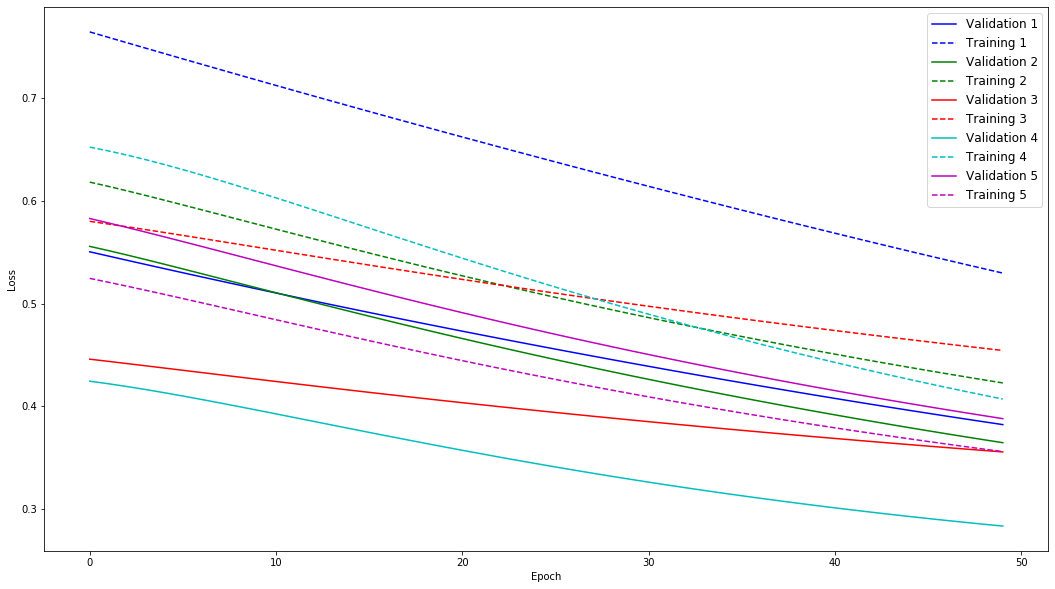

In [6]:
net.train()
colors = ['b', 'g', 'r', 'c', 'm']

plt.figure(figsize=(18,10))

for i in range(5):
    # inizializzo i pesi
    net.apply(init_weights)
    training_loss = []
    validation_loss = []
    
    # shuffle del training e validation set
    loader = torch.utils.data.DataLoader(dataset, batch_size = 126, shuffle=True)
    train, validation = loader
    X_train = train[:,:2]
    y_train = train[:,2]
    y_train = f.normalization2(y_train)
    X_val = validation[:,:2]
    y_val = validation[:,2]
    y_val = f.normalization2(y_val)


    for epoch in tqdm(range(epochs)):
        opt.zero_grad()
        y_pred = net(X_train)
        y_pred = torch.squeeze(y_pred)
        train_loss = loss_fun(y_train, y_pred)
        training_loss.append(train_loss)

        with torch.no_grad():
            y_test = net(X_val)
            y_test = torch.squeeze(y_test)
            val_loss = loss_fun(y_val, y_test)
            assert val_loss.requires_grad == False
            validation_loss.append(val_loss)

        train_loss.backward()
        opt.step()
    
    #plt.figure(figsize=(6,6))
    plt.plot(validation_loss, label=f'Validation {i+1}', ls='-', color=colors[i])
    plt.plot(training_loss, label=f'Training {i+1}', ls='dashed', color=colors[i])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(fontsize=12)